In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import sklearn.base as base
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import train_test_split

# Домашняя работа: ансамбли

Эта домашняя работа является идейным продолжением предыдущей. В данной работе вам будет необходимо поэкспериментировать с различными методами ансамблирования и проверить, какие из них работают лучше. Пайплайн предобработки данных можно взять полностью из предыдущей работы.

Требования к домашней работе:
- Во всех графиках (если вы их строите) должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке. Если в итоге по каким-то причинам тетрадка не будет открываться у преподавателя, задание не будет засчитано
- Использование мемов допускается. Если задания дались тяжело, можно дополнительно приложить какой-нибудь постироничный мем про ваши страдания во время выполнения данной домашней работы. За мемы с использованием нецензурной лексики баллы будут снижены.

# Загрузка и подготовка данных (1 балл)

В этой секции предлагается прогнать предобработку данных из прошлой тетрадки заново и сохранить получившийся датасет в формате csv.

Если вы **не хотите заморачиваться**, то просто скопируйте код с предобработкой ниже.

В противном случае в старой тетрадке:
1. Отдельно выполните предобработку (`fit_transform`) тренировочной части данных
2. Добавьте колонку `split` к датафрейму с обучающей выборкой, в этой колонке проставьте значение `train` для всех объектов
3. Затем примените **только** предобработку (`transform`) к тестовой части данных
4. Добавьте колонку `split` к тестовой выборке, в этой колонке проставьте значение `test` для всех объектов
5. Объедините два датафрейма в один при помощи функции `pd.concat`
6. Сохраните получившийся датафрейм при помощи функции `to_csv`, не забудьте передать аргумент `index=False`

Получившийся файл сохраните отдельно и используйте в этой домашней работе. Для разбиения датасета на обучающую и тестовую части вместо функции `train_test_split` можете применять колонку `split`.

Важно: во всех разделах ниже задачу регрессии важно оценивать не только при помощи `MSE`, но и при помощи `r2_score`. Если вы хотите перебрать какой-либо гиперпараметр, не забывайте оценивать то, насколько сильно переобучается модель и как меняется каждый из параметров в процессе обучения.

In [2]:
df = pd.read_csv('data_preproc_and_split.csv')
X_train= df.loc[df['split']=='train'].drop(columns=['price', 'split'])
X_val_3split = df.loc[df['split']=='validation'].drop(columns=['price', 'split'])
X_test_3split = df.loc[df['split']=='test'].drop(columns=['price', 'split'])
X_test_2split = pd.concat([X_val_3split, X_test_3split], axis=0)

y_train = df.loc[df['split']=='train', 'price']
y_val_3split = df.loc[df['split']=='validation', 'price']
y_test_3split = df.loc[df['split']=='test', 'price']
y_test_2split = pd.concat([y_val_3split, y_test_3split])

# Стекинг (максимум 3 балла)

Решите задачу, используя разные комбинации базовых моделей. В качестве базовой модели обязательно попробуйте линейную регрессию, дерево и SVM для регрессии.

Какой набор моделей дает лучший результат? Попробуйте улучшить его, перебрав несколько гиперпараметров (как у базовой модели, так и у ансамбля).

## Простой стекинг своими руками (2 балла)

In [9]:
class KFoldCrossValidation:
    @staticmethod
    def k_split(X: pd.DataFrame, y: pd.Series, k: int):
        if k == 0:
            yield X, y, None, None
            return
        part_sizes = [x.shape[0] for x in np.array_split(X, k)]
        start_index = 0
        for part_size in part_sizes:
            stop_index = start_index + part_size
            yield X.drop(X.index[start_index: stop_index]), y.drop(y.index[start_index: stop_index]), X.iloc[start_index: stop_index], y.iloc[start_index: stop_index]
            start_index = stop_index
                

    @staticmethod
    def k_split_pred(X: pd.DataFrame, k: int):
        if k == 0:
            yield X
            return
        part_sizes = [x.shape[0] for x in np.array_split(X, k)]
        start_index = 0
        for part_size in part_sizes:
            stop_index = start_index + part_size
            yield X.iloc[start_index: stop_index]
            start_index = stop_index

class StackingBlendingRegressionSolver:
    def __init__(self, base_estimators: dict, meta_estimator, k_folds: int):
        self._base_estimators = base_estimators
        self._meta_estimator = meta_estimator
        self._k_folds = k_folds

    def _fit_base(self, X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
        base_estimators_by_fold = []
        for X_t, y_t, X_v, y_v in KFoldCrossValidation.k_split(X, y, self._k_folds):
            current_base_estimators_by_fold = {}
            for model_name, base_estimator in self._base_estimators.items():
                base_estimator_copy = base.clone(base_estimator, safe=True)
                base_estimator_copy.fit(X_t, y_t)
                current_base_estimators_by_fold[model_name] = base_estimator_copy
            base_estimators_by_fold.append(current_base_estimators_by_fold)
        self.base_estimators_by_fold = base_estimators_by_fold

    def _predict_base(self, X: pd.DataFrame) -> pd.DataFrame:
        predictions = {k: [] for k in self._base_estimators.keys()}
        for i, fold in enumerate(KFoldCrossValidation.k_split_pred(X, self._k_folds)):
            base_estimators = self.base_estimators_by_fold[i]
            for model_name, base_estimator_copy in base_estimators.items():
                pred = base_estimator_copy.predict(fold)
                predictions[model_name].extend(pred)
        return pd.DataFrame(predictions)

    def fit_stacking(self, X: pd.DataFrame, y: pd.Series):
        self._fit_base(X, y)
        base_train_predictions = self._predict_base(X)
        self._meta_estimator.fit(base_train_predictions, y)
    
    def fit_blending(self, X_train: pd.DataFrame, X_val: pd.DataFrame, y_train: pd.Series, y_val: pd.Series):
        self._fit_base(X_train, y_train)
        base_val_predictions = self._predict_base(X_val)
        self._meta_estimator.fit(base_val_predictions, y_val)
    
    def predict_stacking_blending(self, X: pd.DataFrame) -> pd.Series:
        return self._meta_estimator.predict(self._predict_base(X))

In [4]:
from itertools import combinations

base_models = {'svm_regression': SVR(), 'linear_regression': LinearRegression(), 'decision_tree': DecisionTreeRegressor(),
            'bayesian_ridge': BayesianRidge()}
model_combinations = combinations(base_models.keys(), 3)
current_combo_to_scores = {}
for model_combination in model_combinations:
    current_combination = {model_name: base_models[model_name] for model_name in model_combination}
    stacking_regressor = StackingBlendingRegressionSolver(base_estimators=current_combination, meta_estimator=LinearRegression(), k_folds=0)
    stacking_regressor.fit_stacking(X_train, y_train)
    y_pred = stacking_regressor.predict(X_test_2split)
    current_mse, current_r2 = mse(y_test_2split, y_pred), r2_score(y_test_2split, y_pred)
    current_combo_to_scores[str(current_combination.keys())] = [current_mse, current_r2]

In [8]:
for k, scores in current_combo_to_scores.items():
    print('models are: {0}; MSE is {1}, R2 is {2}'.format(k, scores[0], scores[1]))

models are: dict_keys(['svm_regression', 'linear_regression', 'decision_tree']); MSE is 1849.4232088705191, R2 is -0.18394707601646187
models are: dict_keys(['svm_regression', 'linear_regression', 'bayesian_ridge']); MSE is 1.024246272081944e+21, R2 is -6.556927441679351e+17
models are: dict_keys(['svm_regression', 'decision_tree', 'bayesian_ridge']); MSE is 1841.3721738721342, R2 is -0.17879303701688354
models are: dict_keys(['linear_regression', 'decision_tree', 'bayesian_ridge']); MSE is 1812.8251865456782, R2 is -0.16051808404120527


In [79]:
from sklearn.metrics import mean_squared_error as mse, r2_score

base_estimators={'bayesian_ridge': BayesianRidge(), 'linear_regression': LinearRegression(), 'decision_tree': DecisionTreeRegressor()}
stacking_regressor = StackingBlendingRegressionSolver(base_estimators=base_estimators, meta_estimator=LinearRegression(), k_folds=10)
stacking_regressor.fit_stacking(X_train, y_train)
y_pred_stacking = stacking_regressor.predict_stacking_blending(X_test_2split)

print('MSE is {0}; R2 is {1}'.format(mse(y_test_2split, y_pred_stacking), r2_score(y_test_2split, y_pred_stacking)))

MSE is 1526.1040434445956; R2 is 0.13686883242238346


Лучшие MSE и R2 показали бустинги из BayesianRidge, линейной регрессии и деревьев с набором k-folds=10. Может быть можно и больше фолдов делать, но тогда модель начинает долго обучаться

## Использование встроенной модели стекинга (0.5 балла)

In [86]:
sk_stacking_estimators = [('lin_reg', LinearRegression()), ('tree', DecisionTreeRegressor()), ('SVM regression', SVR())]
sk_stacking_regressor = StackingRegressor(estimators=sk_stacking_estimators, final_estimator=LinearRegression(), cv=10)
sk_stacking_regressor.fit(X_train, y_train)
sk_stacking_predictions = sk_stacking_regressor.predict(X_test_2split)
print('MSE is {0}; R2 is {1}'.format(mse(y_test_2split, sk_stacking_predictions), r2_score(y_test_2split, sk_stacking_predictions)))

MSE is 1635.1101742414878; R2 is 0.07521734191491103


Базовые эстиматоры с BayesianRidge не сходятся в sklearn.StackingRegressor. Потому использую SVR() вместо BayesianRidge()

## Блендинг (0.5 балла)

Реализуйте схему блендинга. Для этого разбейте **тестовую** выборку на *валидационную* и *тестовую* части, при необходимости также доработайте код класса `StackingRegressionSolver`. Используйте для обучения базовых моделей обучающую выборку, а для обучения метамодели - валидационную.

Как изменилось качество? Как вы думаете, правдоподобнее ли выглядит такой результат?

In [28]:
blending_regressor = StackingBlendingRegressionSolver(base_estimators={'svm_regression': SVR(), 'linear_regression': LinearRegression(), 'decision_tree': DecisionTreeRegressor()},
                                                       meta_estimator=LinearRegression(), k_folds=10)
blending_regressor.fit_blending(X_train, X_val_3split, y_train, y_val_3split)
blending_predictions = blending_regressor.predict_stacking_blending(X_test_3split)
print('MSE is {0}; R2 is {1}'.format(mse(y_test_3split, blending_predictions), r2_score(y_test_3split, blending_predictions)))

MSE is 1453.4191840467795; R2 is 0.0695632103431173


Результат выглядит лучше, чем на стекинге с теми же параметрами и с теми же моделями. Скорее всего это из-за того, что блендинг меньше оверфитится, чем стекинг из за того, что для предсказаний base-learner-ов используется validation датасет

# Бэггинг (максимум 3 балла)

В этой секции аналогично нужно решить задачу при помощи бэггинга - сначала написанного самостоятельно, а затем взятого из sklearn.

## Бэггинг своими руками (2 балла)

Решите задачу, используя в качестве базовой модели линейную регрессию, дерево и SVM. Какой из алгоритмов в качестве базовой модели дает лучший результат? Почему, как вы думаете?

In [88]:
from typing import Tuple


class BaggingRegressionSolver:
    def __init__(
        self,
        base_estimator_ctor,
        max_samples: float = 1,
        n_estimators: int = 10,
        sample_random_states=np.tile([42], 10),
        **model_kwargs
    ):
        if max_samples < 0 or max_samples > 1 or len(sample_random_states) != n_estimators:
            raise ValueError
        self._estimators = [
            base_estimator_ctor(**model_kwargs) for _ in range(n_estimators)
        ]
        self._max_samples = max_samples
        self._random_states = sample_random_states

    def _sample_data(self, X: pd.DataFrame, y: pd.Series, i: int) -> Tuple[pd.DataFrame, pd.Series]:
        x_i = X.sample(frac=self._max_samples, random_state=self._random_states[i], replace=True)
        y_i = y.loc[x_i.index]
        return x_i, y_i

    def fit(self, X: pd.DataFrame, y: pd.Series):
        for i, estimator in enumerate(self._estimators):
            x_i, y_i = self._sample_data(X, y, i)
            estimator.fit(x_i, y_i)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        return np.mean([estimator.predict(X) for estimator in self._estimators], axis=0)
    

In [20]:
random_states = [np.random.randint(0, 100) for _ in range(50)]

In [99]:
bagging_regressor = BaggingRegressionSolver(base_estimator_ctor = DecisionTreeRegressor, max_samples=.7, n_estimators=30, sample_random_states=random_states[:30])
bagging_regressor.fit(X_train, y_train)
bagging_pred = bagging_regressor.predict(X_test_2split)
print('MSE is {0}; R2 is {1}'.format(mse(y_test_2split, bagging_pred), r2_score(y_test_2split, bagging_pred)))

MSE is 1567.0327112300424; R2 is 0.11372047044483946


SVM 10 estimators: MSE is 1851.6941183945812; R2 is -0.04727781390256425 </br>
Linear regression 10 estimators: MSE is 7.648747935445008e+20; R2 is -4.325965037826866e+17 </br>

Tree 30 estimators: MSE is 1567.0327112300424; R2 is 0.11372047044483946 </br>
Tree 20 estimators: MSE is 1575.2572564080199; R2 is 0.10906884704291231 </br>
Tree 10 estimators: MSE is 1675.5472771765712; R2 is 0.0523469982972925 </br>

Лучший результат показывает дерево как модель с high variance. А бэггингом мы просто усредняем variance деревьев, чтобы деревья, которые были "переобучены" на разных частях датасета, были скомпенсированы теми деревьями, которые не видели данные сэмплы и предсказывают что-то близкое к истинному значению target.
Тут хорошо объясняет это поведение картинка из Википедии: </br>
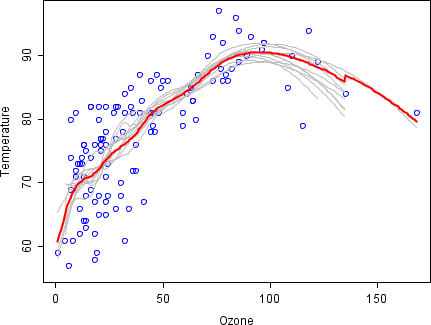

## Использование встроенной модели бэггинга (1 балл)

Решите задачу, используя:
- `sklearn.ensemble.BaggingRegressor`. В качестве базовой модели попробуйте линейную регрессию, дерево и SVM
- `sklearn.ensemble.RandomForestRegressor`

Какая модель дает лучший результат? Попробуйте улучшить его, перебрав несколько гиперпараметров (как у базовой модели, так и у ансамбля).



In [59]:
sk_bagging_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, max_samples=.7, bootstrap=True, random_state=random_states[0])
sk_bagging_regressor.fit(X_train, y_train)
sk_bagging_pred = sk_bagging_regressor.predict(X_test_2split)
print('MSE is {0}; R2 is {1}'.format(mse(y_test_2split, sk_bagging_pred), r2_score(y_test_2split, sk_bagging_pred)))

MSE is 1560.3009472225124; R2 is 0.11752780936949225


В sklearn.ensemble.BaggingRegressor применялись следующие base_estimator-ы </br>
Decision tree: MSE is 1560.3009472225124; R2 is 0.11752780936949225 </br>
SVR: MSE is 1850.6996241752856; R2 is -0.04671534965883395 </br>
Linear regression: MSE is 1.4369323931202434e+20; R2 is -8.126976266995267e+16 </br>


In [61]:
sk_random_forest_regressor = RandomForestRegressor(n_estimators=10, max_samples=.7, bootstrap=True, random_state=random_states[0])
sk_random_forest_regressor.fit(X_train, y_train)
sk_rand_forest_pred = sk_random_forest_regressor.predict(X_test_2split)
print('MSE is {0}; R2 is {1}'.format(mse(y_test_2split, sk_rand_forest_pred), r2_score(y_test_2split, sk_rand_forest_pred)))

MSE is 1568.674677141656; R2 is 0.11279181033119812


# Бустинг (максимум 3 балла)

## Бустинг своими руками (2 балла)

Решите задачу при помощи алгоритма бустинга, используя в качестве базовой модели:
- Линейную регрессию
- Дерево
- Случайный лес

Какая модель дает лучший результат? Попробуйте улучшить его, перебрав несколько гиперпараметров (как у базовой модели, так и у ансамбля).

In [61]:
from abc import ABC, abstractmethod
from collections import deque
from typing import Tuple

from sklearn.dummy import DummyRegressor


class Loss(ABC):
    """
    Базовый класс для функции потерь
    """
    @abstractmethod
    def forward(self, y_true: pd.Series, y_pred: pd.Series) -> float:
        """
        Метод, вычисляющий значение функции потерь
        """
        pass

    @abstractmethod
    def backward(self, y_true: pd.Series, y_pred: pd.Series) -> pd.Series:
        """
        Метод, вычисляющий значение АНТИградиента функции потерь по предсказаниям модели
        """
        pass


class MSELoss(Loss):
    def forward(self, y_true: pd.Series, y_pred: pd.Series) -> float:  # посчитаем значение ошибки
        return ((y_pred - y_true) ** 2).mean()

    def backward(self, y_true: pd.Series, y_pred: pd.Series) -> pd.Series:  # посчитаем отрицательную производную по выходам модели
        return y_true - y_pred


class GradientBoostingRegressionSolver:
    def __init__(
        self,
        base_estimator_ctor,
        n_estimators: int = 10,
        loss: Loss = MSELoss(),
        learning_rate: float = 0.1,
        early_stopping: int = 5,
        **model_kwargs
    ):
        if early_stopping < 0:
            raise ValueError

        self._ctor = base_estimator_ctor
        self._kwargs = model_kwargs
        self._n_estimators = n_estimators
        self._estimators = []
        self._early_stopping = early_stopping
        self._loss = loss
        self._lr = learning_rate
        self._random_state = 42

    def _sample_data(self, X: pd.DataFrame, y: pd.Series, frac: float) -> Tuple[pd.DataFrame, pd.Series]:
        x_sample = X.sample(frac=frac, random_state=self._random_state)
        y_sample = y.loc[x_sample.index]
        return x_sample, y_sample

    def _split_data(self, X: pd.DataFrame, y: pd.Series, val_size: float) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
        x_val, y_val = self._sample_data(X, y, val_size)
        x_train, y_train = X[~X.index.isin(x_val.index)], y[~y.index.isin(y_val.index)]
        return x_train, x_val, y_train, y_val

    def predict(self, X: pd.DataFrame) -> pd.Series:
        # Прогоним данные, поступившие на вход, через все модели в ансамбле и сложим ответы
        predictions = pd.Series(np.zeros(X.shape[0]))
        for i, estimator in enumerate(self._estimators):
            if i == 0:
                predictions += estimator.predict(X)
            else:
                predictions += estimator.predict(X) * self._lr
        return predictions
    
    def fit(self, X: pd.DataFrame, y: pd.Series, val_size: float = 0.1):
        x_train, x_val, y_train, y_val = self._split_data(X, y, val_size)  # Хотим получить валидационную выборку, не тратя на это время снаружи
        base_estimator = DummyRegressor(strategy='mean')  # Создадим и обучим базовую модель
        base_estimator.fit(x_train, y_train)
        self._estimators.append(base_estimator)  # Добавим базовую модель в список моделей

        y_pred_train, y_pred_val = base_estimator.predict(x_train), base_estimator.predict(x_val)
        train_loss, val_loss = self._loss.forward(y_train, y_pred_train), self._loss.forward(y_val, y_pred_val)  # Посчитаем значение функции потерь для обучения и валидации
        residuals = self._loss.backward(y_train, y_pred_train)  # Посчитаем остатки, используя градиент функции потерь
        print(f'train loss: {train_loss}, val loss: {val_loss}')

        previous_val_loss, cnt = val_loss, 0
        for i in range(self._n_estimators - 1):
            estimator = self._ctor(**self._kwargs)  # Создадим очередную модель
            estimator.fit(x_train, residuals)
            self._estimators.append(estimator)
            # считаем MSE
            current_model_pred_train = base_estimator.predict(x_train)
            current_model_pred_val =  base_estimator.predict(x_val)
            for pred_estimator in self._estimators[1:]:
                current_model_pred_train += pred_estimator.predict(x_train) * self._lr
                current_model_pred_val += pred_estimator.predict(x_val) * self._lr
            previous_val_loss = val_loss
            train_loss = self._loss.forward(y_train, current_model_pred_train)
            val_loss = self._loss.forward(y_val, current_model_pred_val)
            print(f'train loss: {train_loss}, val loss: {val_loss}')
            if np.abs(previous_val_loss - val_loss) < 1e-6:
                cnt += 1
                if cnt >= self._early_stopping:
                    return
            else:
                cnt = 0
            residuals = self._loss.backward(y_train, current_model_pred_train)
            
            # 1. Обучим её и добавим в список моделей
            # 2. Предскажем ВСЕМ ансамблем данные из обучающей выборки, то же самое сделаем для валидационной
            # 3. Посчитаем значения функции потерь (на обучении и валидации)
            # 4. Обновим остатки для обучающей выборки
            # Если валидационный лосс несколько (self._early_stopping) шагов подряд не уменьшается, то остановим обучение

Вопросы на дополнительный балл:
- Почему градиент по ответам мы берем со знаком минус?
- Почему в обучении мы домножаем на `learning_rate`, а в предсказаниях этого не делаем?

 - Градиент берем со знаком минус, так как мы хотим идти в сторону убывания нашей MSE
 - В обучении домножаем на `learning_rate`, чтобы сойтись к target-у **ВСЕМИ** эстиматорами. Если мы не будем домножать, то мы просто переобучим нашу первую модель(которая сразу после dummy идет), так как мы учим на train и делаем предсказания на train, а остальные модели просто будут предсказывать какие-то маленькие ошибки после предсказаний переобученной первой модели </br>
 Если честно, то не могу сказать, почему мы этого не делаем в предсказаниях. Потому что если не домножать, то получаются R2 ~ -12.51 и MSE~23898 - то есть лучше уже просто среднее предсказывать. И действительно, если все наши `estimator-ы` учились предсказывать целые остатки от target(i) = y - target(i-1) * lr, то почему тогда наши предсказания должны быть точными без домножения каждого предсказания на `learning_rate`, либо всего предсказания на `learning_rate`? А вот c lr=0.1 получаются достаточно хорошие счета. Я оставлю в коде `.predict()` предсказания с `* self._lr` просто на основе моих догадок и результатов MSE и R2 для нашего бустинга.

In [62]:
my_gboost = GradientBoostingRegressionSolver(base_estimator_ctor=RandomForestRegressor, n_estimators = 10, learning_rate=.1, early_stopping=5,
                                            )
my_gboost.fit(X_train, y_train, val_size=0.1)
my_boost_pred = my_gboost.predict(X_test_2split)
print('MSE is {0}; R2 is {1}'.format(mse(y_test_2split, my_boost_pred), r2_score(y_test_2split, my_boost_pred)))

train loss: 2484.390174712076, val loss: 1600.5456115437873
train loss: 2149.7310250533624, val loss: 1551.8703941885722
train loss: 1862.3490642944087, val loss: 1511.9114845931897
train loss: 1613.5914735783408, val loss: 1486.9552050850791
train loss: 1429.699797621396, val loss: 1468.293627559289
train loss: 1245.638182479998, val loss: 1454.507776113519
train loss: 1082.4679335990063, val loss: 1445.876628538027
train loss: 946.8173987110039, val loss: 1442.1084229633695
train loss: 824.3566229108037, val loss: 1440.5919448098557
train loss: 720.4907053399517, val loss: 1440.7380181132821
MSE is 1562.5094088203527; R2 is 0.11627875164916024


Tree with default params, n_estimators = 20. MSE is 1931.5738460211035; R2 is -0.0924560459295507 </br>
Tree with default params, n_estimators = 10. MSE is 1803.778417792517; R2 is -0.020177738528535105 </br>
random forest with default params, n_estimators=10. MSE is 1562.5094088203527; R2 is 0.11627875164916024

Лучшие результаты показывает RandomForestRegressor, но он очень долго учится, если даже ставить n_estimators=10

# Catboost (1 балл)

Решите эту же задачу при помощи `catboost`, не перебирая гиперпараметры. Насколько лучше или хуже справился катбуст? В качестве эксперимента также попробуйте закинуть в него данные без предобработки (разумеется, выкинув ненужные колонки). Изменилось ли качество? Каким образом?

In [22]:
def transform_y(target: pd.Series):
    return target.astype('str').apply(lambda x: x.replace('£', '').replace(',', '')).astype(float)

In [23]:
from catboost import CatBoostRegressor

catboost_regressor = CatBoostRegressor(verbose=False, random_state=random_states[0])
catboost_regressor.fit(X_train, y_train)
predictions_catboost = catboost_regressor.predict(X_test_2split)
print('Catboost with processed data: MSE is {0}; R2 is {1}'.format(mse(y_test_2split, predictions_catboost), r2_score(y_test_2split, predictions_catboost)))

df_non_processed = pd.read_csv('data.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])
df_non_processed = df_non_processed.astype(dtype={'manufacturer':'str', 'number_available_in_stock': 'str', 'average_review_rating': 'str', 'amazon_category_and_sub_category': 'str'
                                                  , 'number_of_answered_questions': 'str', 'number_of_reviews': 'str'})
X, y = df_non_processed.drop(columns=['price']), transform_y(target = df_non_processed.price)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size = 0.4, random_state=78)
catboost_regressor_non_processed_data = CatBoostRegressor(verbose=False, random_state=random_states[0])
catboost_regressor_non_processed_data.fit(X_train_raw, y_train_raw, cat_features=['manufacturer', 'number_available_in_stock', 'average_review_rating', 'amazon_category_and_sub_category', 'number_of_answered_questions',
                                                                                  'number_of_reviews'])
predictions_raw_catboost = catboost_regressor_non_processed_data.predict(X_test_raw)
print('Catboost with raw data: MSE is {0}; R2 is {1}'.format(mse(y_test_raw, predictions_raw_catboost), r2_score(y_test_raw, predictions_raw_catboost)))

Catboost with processed data: MSE is 1485.2640461264857; R2 is 0.1599670443172181
Catboost with raw data: MSE is 1601.899046543517; R2 is 0.07775713055003364


Catboost меня значительно обогнал и по скорости обучения, и по MSE и R2. Мой случайный лес учился 5 минут где-то с n_estimators=10, а catboost учился 5 секунд 🥲 </br> Catboost показал меньший MSE и больший R2 на модели с предобработанными данными.